In [1]:
sec_norm = 410
n = 30  # Number of values to predict at a time
input_size = n  # Input is a window of size n
k = 50 # Hidden size
output_size = n  # Output is a window of size n
num_epochs = 100
batch_size = 16
learning_rate = 0.001
cutoff = 50 #cutting of time it takes to lift off
norm_upper = 3.7
norm_lower = 2.3
train_dir = (['data/5-2-25/'])
test_dir = (['data/31-1-25/'])

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import maketab as mt
from torch.utils.data import Dataset, DataLoader

In [3]:
def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    return signal

def normalize(arr):
    min_val = min(arr)
    max_val = max(arr)
    print(min_val, max_val)
    if min_val == max_val:
        return [0.0] * len(arr)  # Avoid division by zero if all elements are the same
    return [(x - min_val) / (max_val - min_val) for x in arr]

def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    secleft = t[-1]/1000
    tleft = 1 - t / max(t)
    tleft = tleft*(secleft/sec_norm)
    signal = norm(signal[cutoff:])
    tleft = tleft[cutoff:]
    t = t[cutoff:]
    normalized_train = np.array([signal, tleft])
    return normalized_train

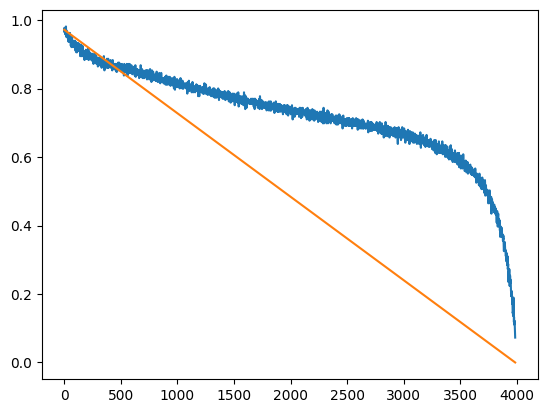

In [4]:
for d in train_dir:
    train_data = load_data(d)
    plt.plot(train_data[0])
    plt.plot(train_data[1])
    plt.show()

In [52]:
class FunctionDataset(Dataset):
    def __init__(self, data, n):
        self.g = data[0]  # Function g
        self.f = data[1]  # Function f
        self.n = n  # Sequence length
        self.total_length = len(self.g)

    def __len__(self):
        # The number of sequences is the total length minus the sequence length plus 1
        return self.total_length - self.n + 1

    def __getitem__(self, idx):
        # Get a sequence of g and the corresponding sequence of f
        g_seq = self.g[idx:idx + self.n]
        f_seq = self.f[idx:idx + self.n]
        
        # Convert to PyTorch tensors
        g_tensor = torch.tensor(g_seq, dtype=torch.float32)
        f_tensor = torch.tensor(f_seq, dtype=torch.float32)
        
        return g_tensor, f_tensor

def create_dataloader(data, seq_length, batch_size=1, shuffle=False):
    dataset = FunctionDataset(data, seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Example usage:
data = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # g
    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # f
])

dataloader = create_dataloader(train_data, n, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
#for g_batch, f_batch in dataloader:
    #print("g_batch:", g_batch)
    #print("f_batch:", f_batch)

In [53]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize model
model = MLP(n, k, n)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
def train(num_epochs, dataloader, model, criterion, optimizer):
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # To accumulate loss for the entire epoch
        for batch_X, batch_Y in dataloader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

In [55]:
for d in train_dir:
    train_data = load_data(d)
    dataloader = create_dataloader(train_data, n, batch_size=batch_size, shuffle=True)
    train(num_epochs, dataloader, model, criterion, optimizer)

Epoch [10/100], Average Loss: 0.1968
Epoch [20/100], Average Loss: 0.0696
Epoch [30/100], Average Loss: 0.0633
Epoch [40/100], Average Loss: 0.0551
Epoch [50/100], Average Loss: 0.0365
Epoch [60/100], Average Loss: 0.0279
Epoch [70/100], Average Loss: 0.0299
Epoch [80/100], Average Loss: 0.0221
Epoch [90/100], Average Loss: 0.0261
Epoch [100/100], Average Loss: 0.0230


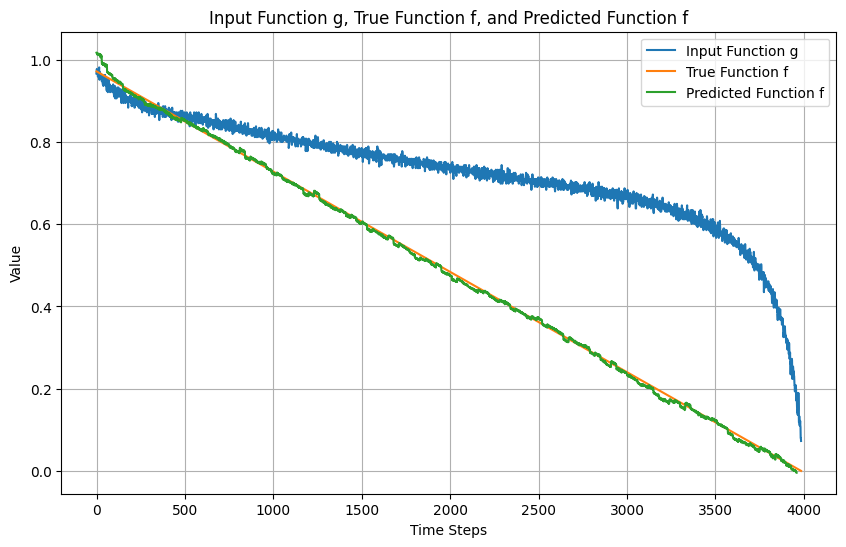

In [56]:
def evaluate_and_plot(data, model, n):
    model.eval()  # Set the model to evaluation mode
    
    g = data[0]  # Input function g
    f = data[1]  # True function f
    
    predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for i in range(0, len(g)-n, n):
            input_seq = g[i:i+n]
            # Convert to PyTorch tensor and add batch dimension
            X = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
            y = model(X)
            predictions.extend(y.squeeze(0).numpy())  # Remove batch dimension and convert to numpy
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(g, label='Input Function g')
    plt.plot(f, label='True Function f')
    plt.plot(predictions, label='Predicted Function f')
    
    # Add labels and legend
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Input Function g, True Function f, and Predicted Function f')
    plt.legend()
    plt.grid(True)
    plt.show()

train_data = load_data('data/5-2-25/')
evaluate_and_plot(train_data, model, n)

In [57]:
checkpoint = {
    'seq_length': n,
    'input_size': n,
    'hidden_size': k,
    'output_size': n,
    'cutoff': cutoff,
    'norm_upper': norm_upper,
    'norm_lower': norm_lower,
    'sec_norm': sec_norm,
    'state_dict': model.state_dict(),
}
torch.save(checkpoint, 'bat_seq_model2.pth')